# <center> Dynamical Friction

In [3]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import os
import time

#config plot
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
%config InlineBackend.figure_format='retina'

We started this simulation by initializating the particle positions following a Plummer sphere. We set the number of particles equal to $3 \times 10^4$ and choose to set the total mass equal to 1 internal units.

In [4]:
N     =  3*10**4
M_tot =  1
b     =  10
m = np.ones(N)*M_tot/N

# <center> Description of the model

Density distribution of a Plummer sphere:


$$\rho(r)=\frac{3M_{tot}}{4\pi b^3}\frac{1}{(1+\frac{r^2}{b^2})^{5/2}}$$


Mass of a Plummer sphere:


$$M(r)=\int_0^r4\pi r'^2\rho(r')dr'=\frac{M_{tot}r^3}{b^3(1+\frac{r^2}{b^2})^{3/2}}=\frac{M_{tot}r^3}{(r^2+b^2)^{3/2}}$$


Radius of the Plummer sphere obtained by inverting the mass formula:


$$r = \left[\left(\frac{M(r)}{M_{tot}}\right)^{-2/3}-1\right]^{-1/2}\cdot b$$

We, then, computed the dynamical time from the density at the scale parameter b.

$$T_{dyn} = \sqrt{\frac{32}{3\pi\rho(b)}}$$

In [5]:
rho   = (3*M_tot)/(4*np.pi*b**3*2**(5/2))
t_dyn = (32/(3*np.pi*rho))**(1/2)
print(t_dyn)

283.6424478370661


We found out that the dynamical time is equal to:$$T_{dyn} = \sqrt{\frac{32}{3\pi\rho(b)}}= 283$$ 

# <center> Distribution of the plummer sphere with Monte Carlo method

Initially, we defined the parameters: $\phi$, $\theta$ and the radius, we then plotted their distributions in three graphs.

In [6]:
np.random.seed(42) #fixing the random seed

In [7]:
#Definition of the parameters we need in order to compute the MC method
#Phi
phi       = np.random.uniform(0,2*np.pi,N)
#Theta
arc_theta = np.random.uniform(0,1,N)
theta     = np.asarray([math.acos(1-2*arc_theta[i]) for i in range(N)])
#Radius
cdf       = np.random.uniform(0,1,N) #cdf = M(R)/M_tot
r         = (cdf**(-2/3)-1)**(-0.5)*b

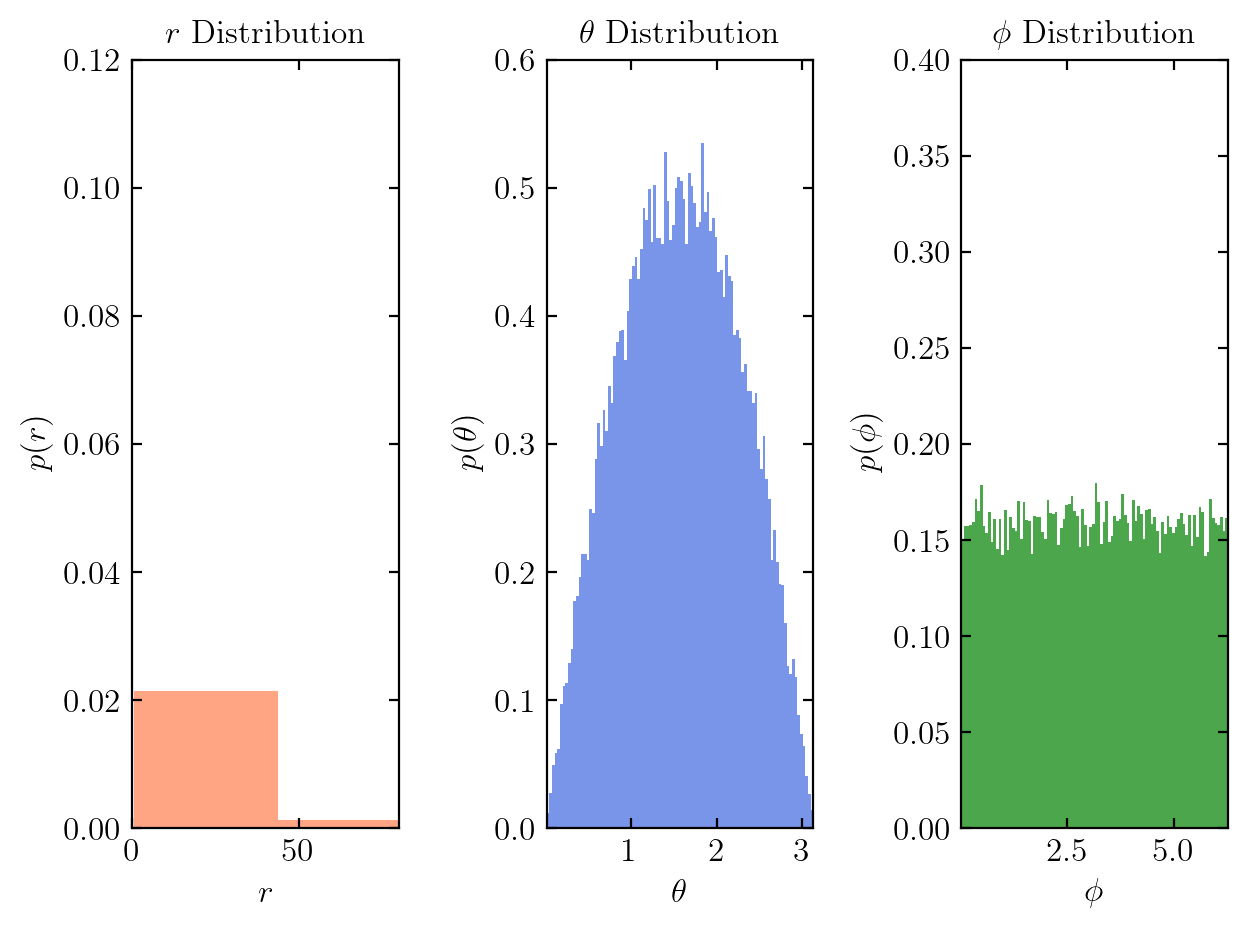

In [8]:
#Distribution of the three parameters in histograms
fig, ax = plt.subplots(1,3, tight_layout=True) 

ax[0].hist(r, bins = 100, color = 'coral', density=True, alpha=.7, lw=0) 
ax[0].set(xlim=(0,80), ylim = (0,0.12), title = fr'$r$ Distribution', xlabel = r'$r$', ylabel=r'$p(r)$') 

ax[1].hist(theta, bins = 100, color = 'royalblue', density=True, alpha=.7, lw=0)
ax[1].set(ylim = (0,0.6), title = fr'$\theta$ Distribution', xlabel = r'$\theta$', ylabel=r'$p(\theta)$')

ax[2].hist(phi, bins = 100, color = 'green', density=True, alpha=.7, lw=0)
ax[2].set(ylim = (0,0.4), title = fr'$\phi$ Distribution', xlabel = r'$\phi$', ylabel=r'$p(\phi)$')
plt.show()

Write the parameters positions in cartesian coordinates.

In [9]:
X=r*np.sin(theta)*np.cos(phi)
Y=r*np.sin(theta)*np.sin(phi)
Z=r*np.cos(theta)

In [10]:
cm_x_i = np.sum(X)/N
cm_y_i = np.sum(Y)/N
cm_z_i = np.sum(Z)/N

# <center> 3D Distribution of the Plummer Sphere

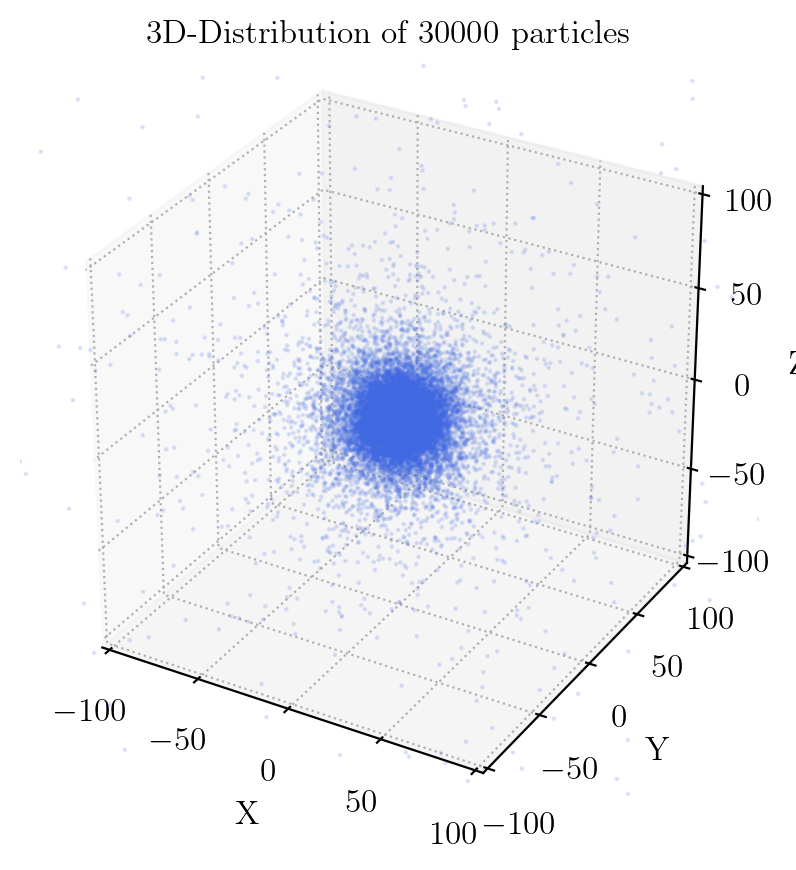

In [11]:
fig = plt.figure()
ax  = plt.axes(projection='3d')
ax.scatter(X,Y,Z,s=.5, color='royalblue',alpha=.15)
ax.set(xlim=(-100,100), ylim = (-100,100), zlim = (-100,100))
ax.set(title = fr'3D-Distribution of {N} particles', xlabel = r'X', ylabel = r'Y', zlabel = r'Z')
ax.set(aspect='equal')


plt.show()

# <center> Monte-Carlo rejection method


From the radius distribution we can get the formula of the potential, from which we can derive the escape velocity. Starting from the cumulative function:

$$F(\epsilon) = \int_{0}^{\epsilon} f(\epsilon)d^3v$$

and assuming that the field is isotropic, we then redifined the velocity as:

$$q= \frac{v}{\sqrt{2\psi}}$$ 

and we got: 

$$F(\epsilon) \propto \int_{0}^{1} (1-q^2)^{7/2}q^2 dq$$

We are unable to invert this equation, so in order to compute a cumulative function, and so an inverse function, we used the Monte-Carlo rejection method.

We wanted to sample:

$$f(\bar{x})\rightarrow g(x) : g(x) > f(x)  \forall x \rightarrow G(x) \rightarrow F(x) $$

Where g(x) is an arbitrary function in order to compute the comulative and the inverse. 

We set: $$y = (1-q^2)^{7/2}q^2$$

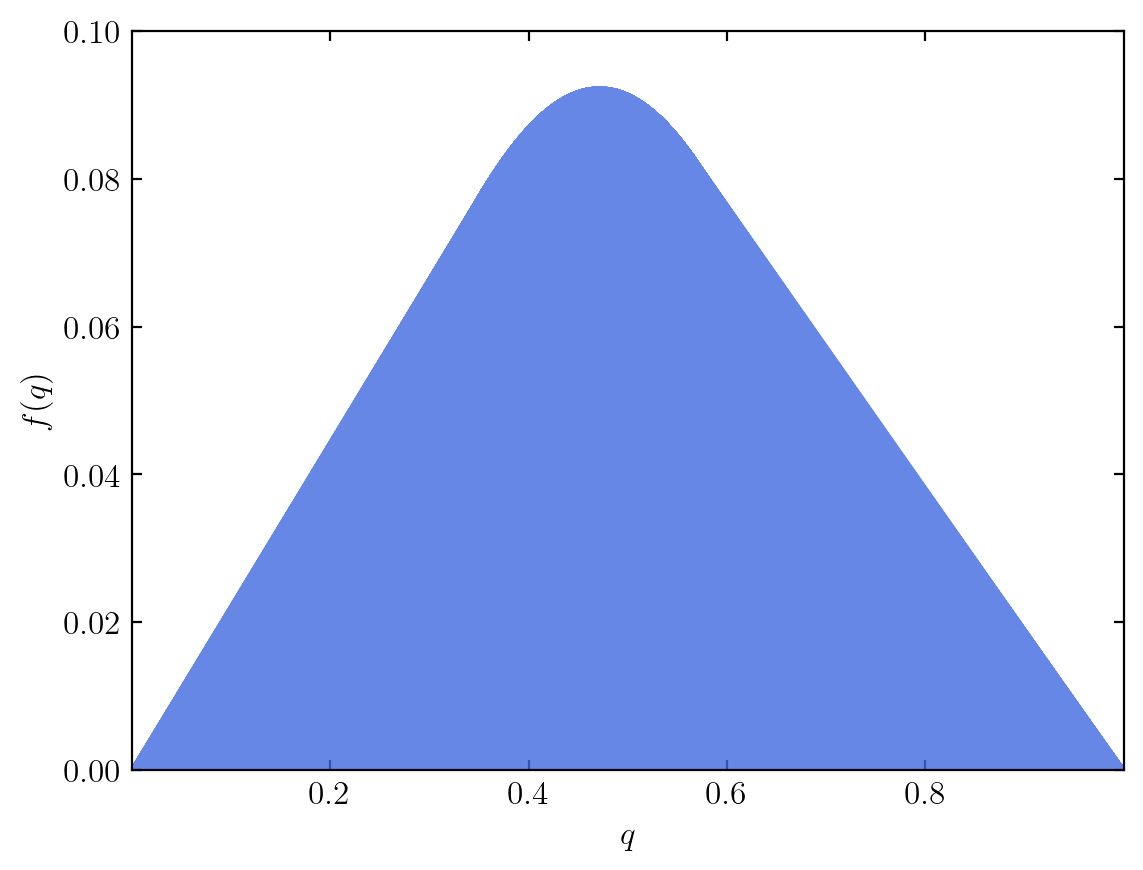

In [12]:
ax = plt.subplot()
q = np.random.uniform(0,1,N)
y = (1-q**2)**(7/2)*q**2
ax.plot(q,y, color='royalblue', alpha = .8)
ax.set(ylim = (0,0.1), xlabel = r'$q$', ylabel = r'$f(q)$')
plt.show()

In [13]:
#Definition of the function for the Monte-Carlo rejection method
def inverse_mc (y):
    g = np.max(y)
    #extract G from 0-g at random
    G = np.random.uniform(0,g)
    #compute the q associated
    q_test = G/g
    #extract h from 0-g at random
    a = (1-q_test**2)**(7/2)*q_test**2
    h = np.random.uniform(0,g)
    #see if reject this or not
    if (h<=a):
        return q_test
    else:
        return -1

In [14]:
Q=np.array([])
while (len (Q)<N):
    temp = inverse_mc(y)
    if (temp!=(-1)):
        Q = np.append(Q,temp)

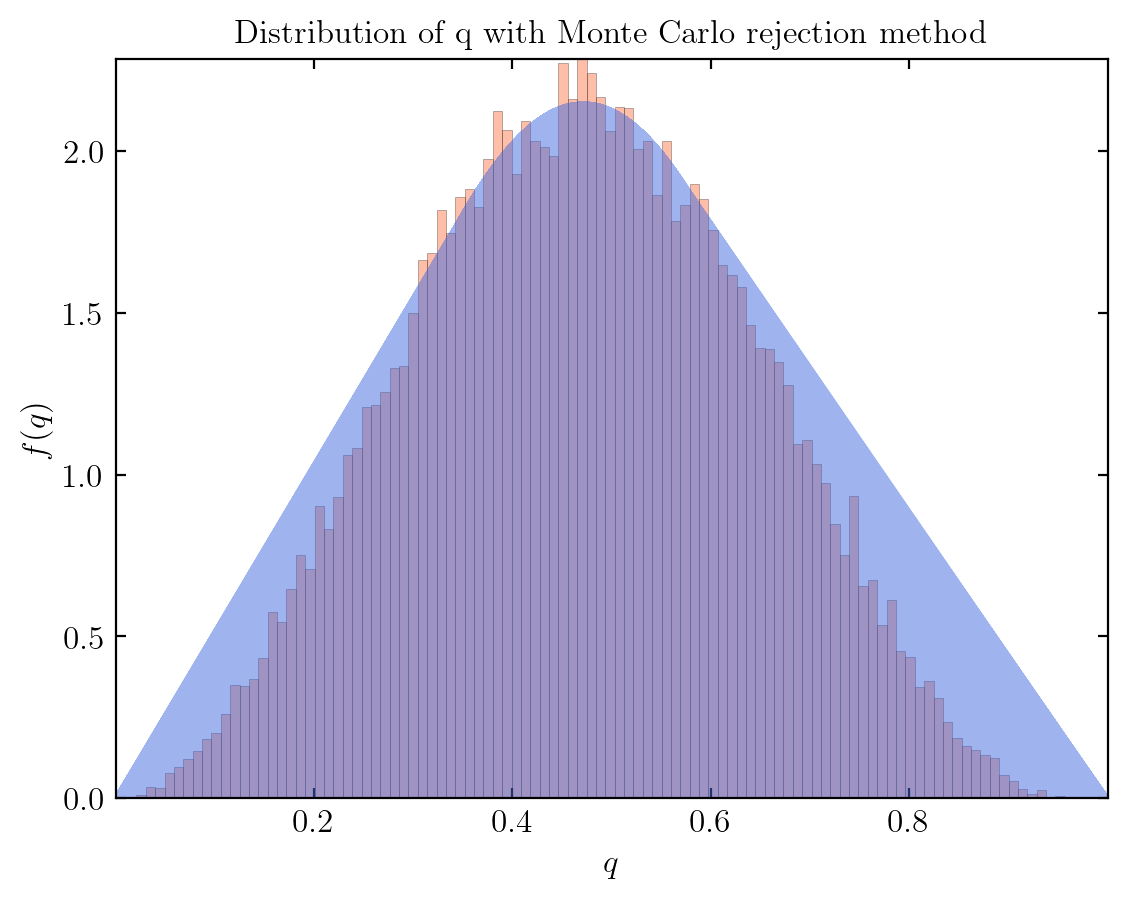

In [15]:
ax = plt.subplot()
ax.plot(q,512*y/(7*np.pi), color='royalblue', alpha = .5)
ax.hist(Q, density = True, alpha = .5, bins = 100, color = 'coral', lw = .2)
ax.set(title = 'Distribution of q with Monte Carlo rejection method', xlabel = 'q', ylabel = 'y')
ax.set(xlabel = r'$q$', ylabel = r'$f(q)$')
plt.show()

Once we found the inverse function through the Monte-Carlo rejection method, we computed the escape velocity.
The potential for the Plummer sphere is:

$$\phi=\frac{-GM_{tot}}{\sqrt{r^2+b^2}}$$

The relative potential is:
$$\psi=-\phi+\phi_0=-\phi$$
We defined $\phi_0$ as a constant.

The escape velocity is:
$$v_{escape}=\sqrt{2\psi}\cdot q$$

In [16]:
#Definition of Phi (relative potential)
Phi   = +M_tot/((r**2+b**2)**(1/2))

#Escape velocity in modulus
v_esc = (2*Phi)**(1/2)*Q
#phi
phi       = np.random.uniform(0,2*np.pi,N)
#theta
arc_theta = np.random.uniform(0,1,N)
theta     = np.asarray([math.acos(1-2*arc_theta[i]) for i in range(N)])

In [17]:
v_x = v_esc*np.sin(theta)*np.cos(phi)
v_y = v_esc*np.sin(theta)*np.sin(phi)
v_z = v_esc*np.cos(theta)

# <center> Adding the perturber

In [18]:
M_p = 0.05
R_p = 25

We can calculate the velocity the perturber experiences by putting it in a **circular orbit** by equating the gravitational force to the centripetal force.
The gravitational force is given by

$$
    F_G = -\dfrac{\partial \phi}{\partial r} = - \dfrac{\partial}{\partial r}\left(\dfrac{GM}{\sqrt{r^2 + b^2}} \right)M_p
$$

we now equate the centripetal force to the gravitational force of the mass enclosed in the perturber orbit

$$
    F_G = F_\mathrm{cp} = \dfrac{mv^2}{r}
$$

from which we find 

$$
    v_\mathrm{p} = \sqrt{\dfrac{M_\mathrm{enc}\ R_p^2}{(R_p^2+b^2)^{3/2}}}
$$

with $M_\mathrm{enc}$ the mass enclosed by the perturber's orbit

In [19]:
raggi_i = (X**2+Y**2+Z**2)**0.5
provv = len([el for el in (raggi_i) if (el<R_p)])
M_inside = provv * M_tot/N
v_p   = ((M_inside*R_p**2)/((R_p**2+b**2)**(3/2)))**(1/2)

m = np.insert(m,0,M_p)
X = np.insert(X,0,0)
Y = np.insert(Y,0,0)
Z = np.insert(Z,0,R_p)
v_x = np.insert(v_x,0,v_p)
v_y = np.insert(v_y,0,0)
v_z = np.insert(v_z,0,0)

In [20]:
f_in = 'initial_data_dyf_005'
f_out = 'out_dyf_005'
f_log = 'log' + f_out

In [21]:
np.savetxt('masses.txt', m)
np.savetxt('positions.txt',np.column_stack((X,Y,Z)))
np.savetxt('velocities.txt', np.column_stack((v_x,v_y,v_z)))

with open(f_in + '.txt', 'w+') as file:
    file.write(repr(N+1)+'\n3\n0\n')
    file.write(open('masses.txt','r').read()+open('positions.txt','r').read()+open('velocities.txt','r').read())

In [22]:
tstop = 3000
dtime = 0.1
eps   = 0.03
theta_ = 0.1
dtout = 15

In [23]:
if (f_out + '.txt' in os.listdir()):
    print('file already exists')
else:
    open(f_out +'.txt', 'w+').close()

In [24]:
print('../tree/treecode in=' + f_in+ '.txt tstop='+ str(tstop) +' dtime='+ str(dtime) +' eps='+str(eps)+' dtout='+ str(dtout) +' out=' + f_out +'.txt > ' + f_log + '.txt')

../tree/treecode in=initial_data_dyf_005.txt tstop=3000 dtime=0.1 eps=0.03 dtout=15 out=out_dyf_005.txt > logout_dyf_005.txt


In [25]:
from time import time

start=time()
#running the code and timing it
os.system('../tree/treecode in=' + f_in + '.txt tstop='+ str(tstop) +' dtime='+ str(dtime) +' eps='+str(eps)+' dtout='+ str(dtout) +' out=' + f_out +'.txt > ' + f_log + '.txt')

end = time()
multi_time = end - start

print("Code took {0:.1f} seconds".format(multi_time))

Code took 4.7 seconds
Code took 4.7 seconds


In [26]:
os.system('cp *.txt ../data')

0

In [27]:
os.system('rm *.txt')

0

### Reading from file

In [29]:
#read the data
data = pd.read_csv('../data/'+ f_out + '.txt', names=list(range(7)), sep = ' ')

Read the data. Positions are computed from the center of mass at each time, not from (0,0,0).

In [30]:
def dati (data,N,M_tot,M_p):
    
    x = []
    y = []
    z = []
    
    v_x = []
    v_y = []
    v_z = []
    
    start = N + 3
    step  = N * 3 + 3
    
    a = (np.array([data.iloc[i::step,:].copy() for i in range(start,start+N)]))
    for j in range(len(a)):
        temp = np.array([a[j][i][~np.isnan(a[j][i])] for i in range(len(a[j]))])
        
        x.append(temp[:,0])
        y.append(temp[:,1])
        z.append(temp[:,2])
        
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    
    b = (np.array([data.iloc[i::step,:].copy() for i in range(start+N,start+N*2)]))
    
    for j in range(len(b)):
        temp = np.array([b[j][i][~np.isnan(b[j][i])] for i in range(len(b[j]))])
        
        v_x.append(temp[:,0])
        v_y.append(temp[:,1])
        v_z.append(temp[:,2])
     

    v_x = np.array(v_x)
    v_y = np.array(v_y)
    v_z = np.array(v_z)
    
    #cm
    cm_x = []
    cm_y = []
    cm_z = []
    
    for i in range (len(x[0])):
        cm_x.append(((np.sum(x.T[i,1:])*M_tot/N)+x.T[i,0]*M_p)/(M_tot+M_p))
        cm_y.append(((np.sum(y.T[i,1:])*M_tot/N)+y.T[i,0]*M_p)/(M_tot+M_p))
        cm_z.append(((np.sum(z.T[i,1:])*M_tot/N)+z.T[i,0]*M_p)/(M_tot+M_p))
       
    print('The final center of mass is (', cm_x[len(x[0])-1],', ', cm_y[len(x[0])-1],', ', cm_z[len(x[0])-1], ')')
    
    x = x - cm_x
    y = y - cm_y
    z = z - cm_z
    
    cm_v_x = []
    cm_v_y = []
    cm_v_z = []
    
    for i in range (len(x[0])):
        cm_v_x.append(((np.sum(v_x.T[i,1:])*M_tot/N)+v_x.T[i,0]*M_p)/(M_tot+M_p))
        cm_v_y.append(((np.sum(v_y.T[i,1:])*M_tot/N)+v_y.T[i,0]*M_p)/(M_tot+M_p))
        cm_v_z.append(((np.sum(v_z.T[i,1:])*M_tot/N)+v_z.T[i,0]*M_p)/(M_tot+M_p))
    
    v_x = v_x - cm_v_x
    v_y = v_y - cm_v_y
    v_z = v_z - cm_v_z
    
    r = np.array([(x[i]**2+y[i]**2+z[i]**2)**0.5 for i in range(N)])
    
    t = (np.array(data.iloc[2::step,:].copy()))[:,2]
    
    return x,y,z,v_x,v_y,v_z,r,t

In [31]:
print('The initial center of mass is (', cm_x_i,', ', cm_y_i,', ', cm_z_i, ')')
x,y,z,v_x,v_y,v_z,r,time = dati(data, N+1, M_tot, M_p)

The initial center of mass is ( -0.07446571686428778 ,  -0.13498117531321782 ,  0.40663219247049964 )
The final center of mass is ( 19.720924310622234 ,  -2.201956356051783 ,  3.325144210947234 )


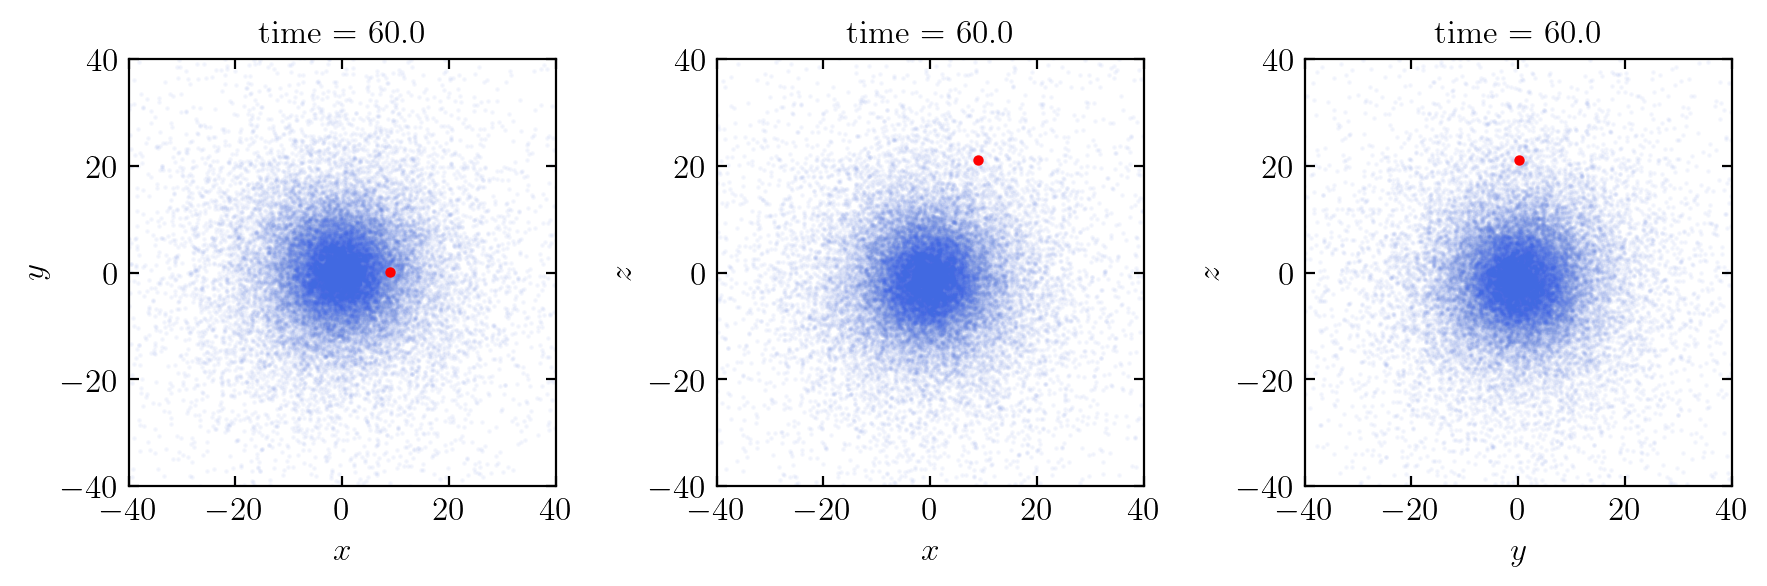

In [32]:
t_i = 4
l = 40

fig, axs = plt.subplots(1,3, figsize = (9,9), tight_layout = True)

for i in range(3):
    axs[i].clear()
    axs[i].set(aspect='equal', xlim = [-l,l], ylim = [-l,l], title = f'time = {round(time[t_i],2)}')

#don't get fooled by shape! the first entry are the particles not the time!
axs[0].scatter(x[:,t_i],y[:,t_i], s = .5, alpha=.05, color = 'royalblue')
axs[0].scatter(x[0,t_i],y[0,t_i], s = 7.5, color = 'red')
axs[0].set(xlabel = r'$x$', ylabel = r'$y$')
axs[1].scatter(x[:,t_i],z[:,t_i], s = .5, alpha=.05, color = 'royalblue')
axs[1].scatter(x[0,t_i],z[0,t_i], s = 7.5, color = 'red')
axs[1].set(xlabel = r'$x$', ylabel = r'$z$')
axs[2].scatter(y[:,t_i],z[:,t_i], s = .5, alpha=.05, color = 'royalblue')
axs[2].scatter(y[0,t_i],z[0,t_i], s = 7.5,color = 'red')
axs[2].set(xlabel = r'$y$', ylabel = r'$z$');

plt.show()

In [ ]:
LX = np.array([((v_z[1:,i]*y[1:,i] - z[1:,i]*v_y[1:,i])*M_tot/N) for i in range(len(time))])
LY = np.array([((-x[1:,i]*v_z[1:,i] + z[1:,i]*v_x[1:,i])*M_tot/N) for i in range(len(time))])
LZ = np.array([((x[1:,i]*v_y[1:,i] - y[1:,i]*v_x[1:,i])*M_tot/N) for i in range(len(time))])

LX=np.sum(LX,axis=1)
LY=np.sum(LY,axis=1)
LZ=np.sum(LZ,axis=1)

L = (LX**2+LY**2+LZ**2)**0.5

LX_p = np.array([((v_z[0,i]*y[0,i] - z[0,i]*v_y[0,i])*M_p) for i in range(len(time))])
LY_p = np.array([((-x[0,i]*v_z[0,i] + z[0,i]*v_x[0,i])*M_p) for i in range(len(time))])
LZ_p = np.array([((x[0,i]*v_y[0,i] - y[0,i]*v_x[0,i])*M_p) for i in range(len(time))])

L_p = (LX_p**2+LY_p**2+LZ_p**2)**0.5

L_tot = L + L_p

plt.plot(time, L_p, label='L perturber')
plt.plot(time, L, label='L sphere')
plt.plot(time, L_tot, label='L tot')
plt.legend()
plt.xlabel('time')
plt.ylabel('L')
plt.margins(.05)
#plt.ylim(0,0.1)
#plt.xlim(0,500)
plt.show()
# :(

plt.clf()
plt.plot(time, LY_p, label='L perturber')
plt.plot(time, LY, label='L sphere')
plt.legend()
plt.xlabel('time')
plt.ylabel('L_y')
plt.margins(.05)
plt.show()

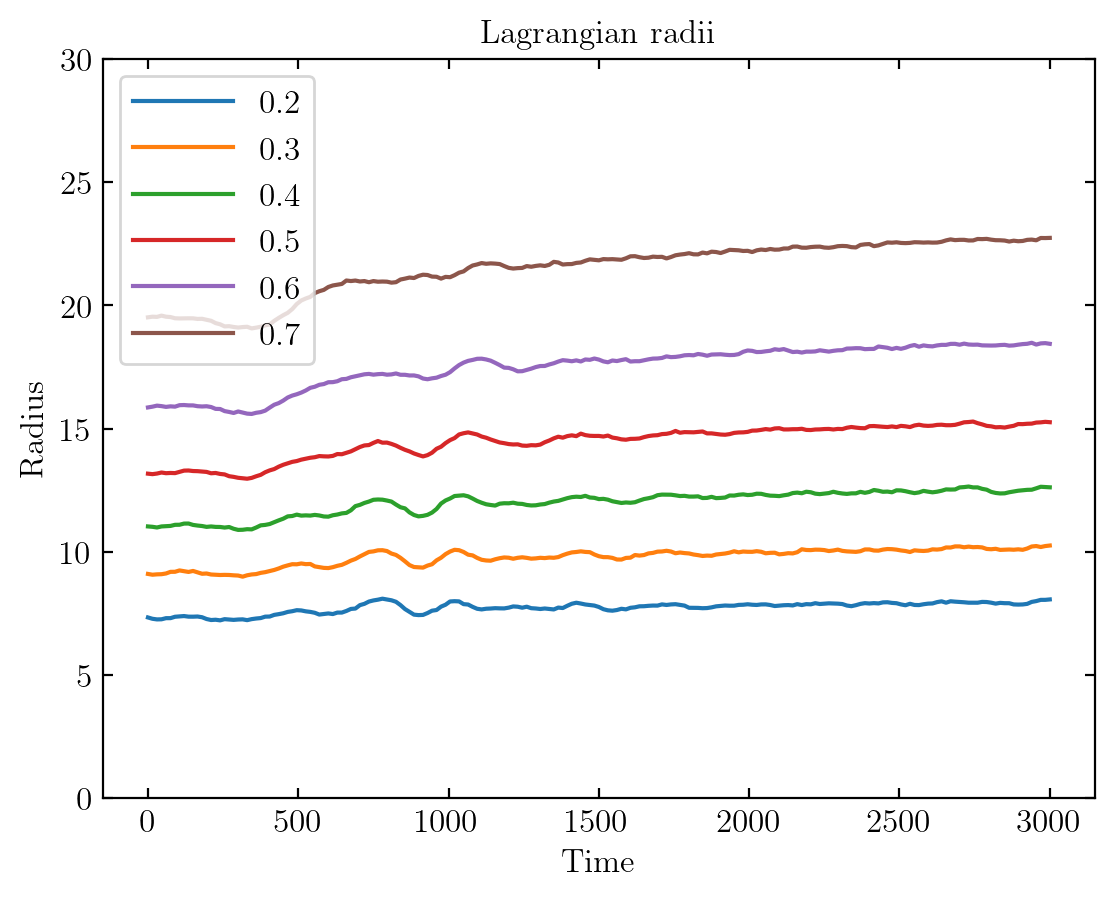

In [35]:
perc = [0.2,0.3,0.4,0.5,0.6,0.7]

for p in perc:
    r_L = []
    for i in range(len(time)):
        a    = np.sort(r[1:,i])
        mask = a<np.quantile(a,p)
        r_L.append(np.max(a[mask]))
    #Plot it
    r_L = np.array(r_L)
    plt.plot(time,r_L, label=str(p))


'''for i in range(0, N, 100):
    plt.plot(time,r[i], alpha=0.1)
'''
plt.ylim(0,30)
plt.xlabel('Time')
plt.ylabel('Radius')
plt.title('Lagrangian radii')
plt.margins(.05)
plt.legend()
plt.show()

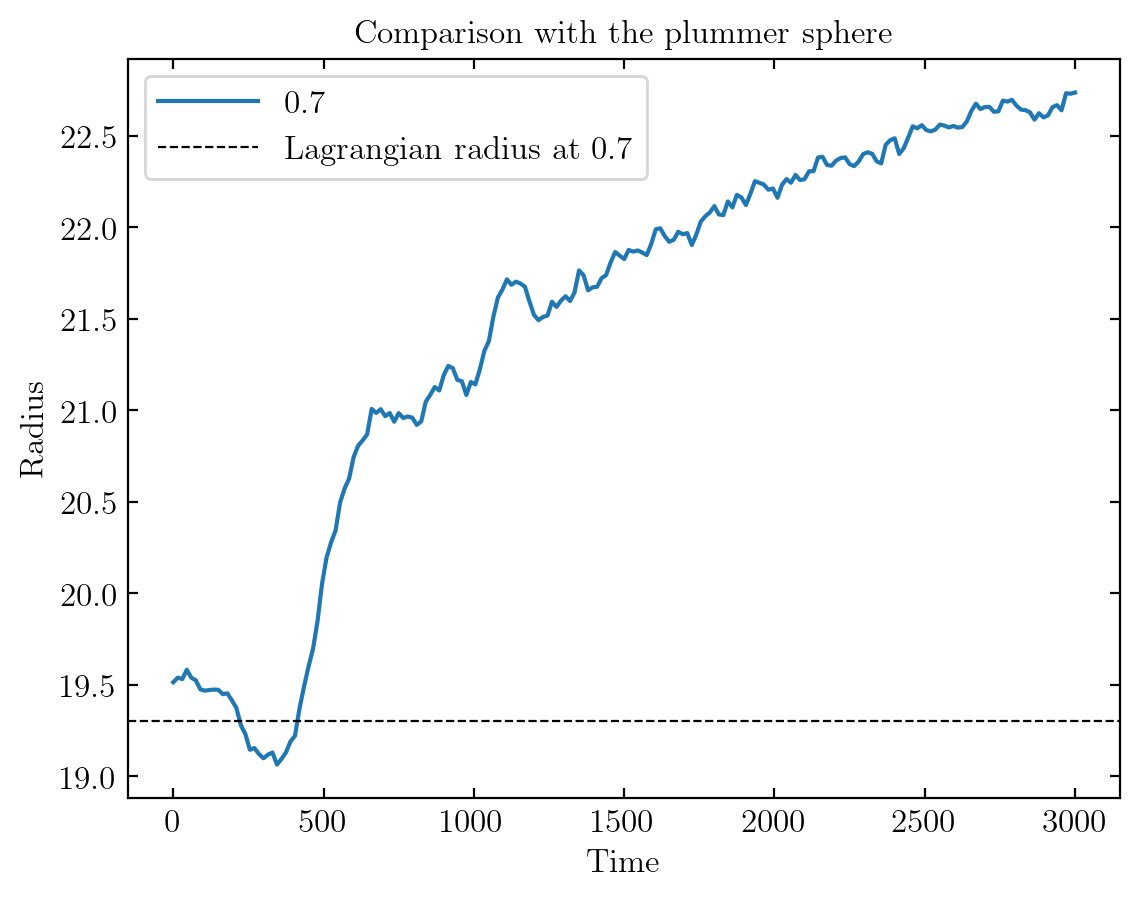

In [36]:
r_L = []
for i in range(len(time)):
    a    = np.sort(r[1:,i])
    mask = a<np.quantile(a,0.7)
    r_L.append(np.max(a[mask]))

#Plot the Lagrangian Radius
r_L = np.array(r_L)
plt.plot(time,r_L, label='0.7')


'''for i in range(0, N, 100):
    plt.plot(time,r[i], alpha=0.1)
'''
lagr = (0.7**(-2/3)-1)**(-0.5)*b   
plt.axhline(lagr, color = 'black', ls = '--', lw = .8, label='Lagrangian radius at 0.7')
#plt.ylim(9.5,9.9)
plt.xlabel('Time')
plt.ylabel('Radius')
plt.margins(.05)
plt.title('Comparison with the plummer sphere')
plt.legend()
plt.show()

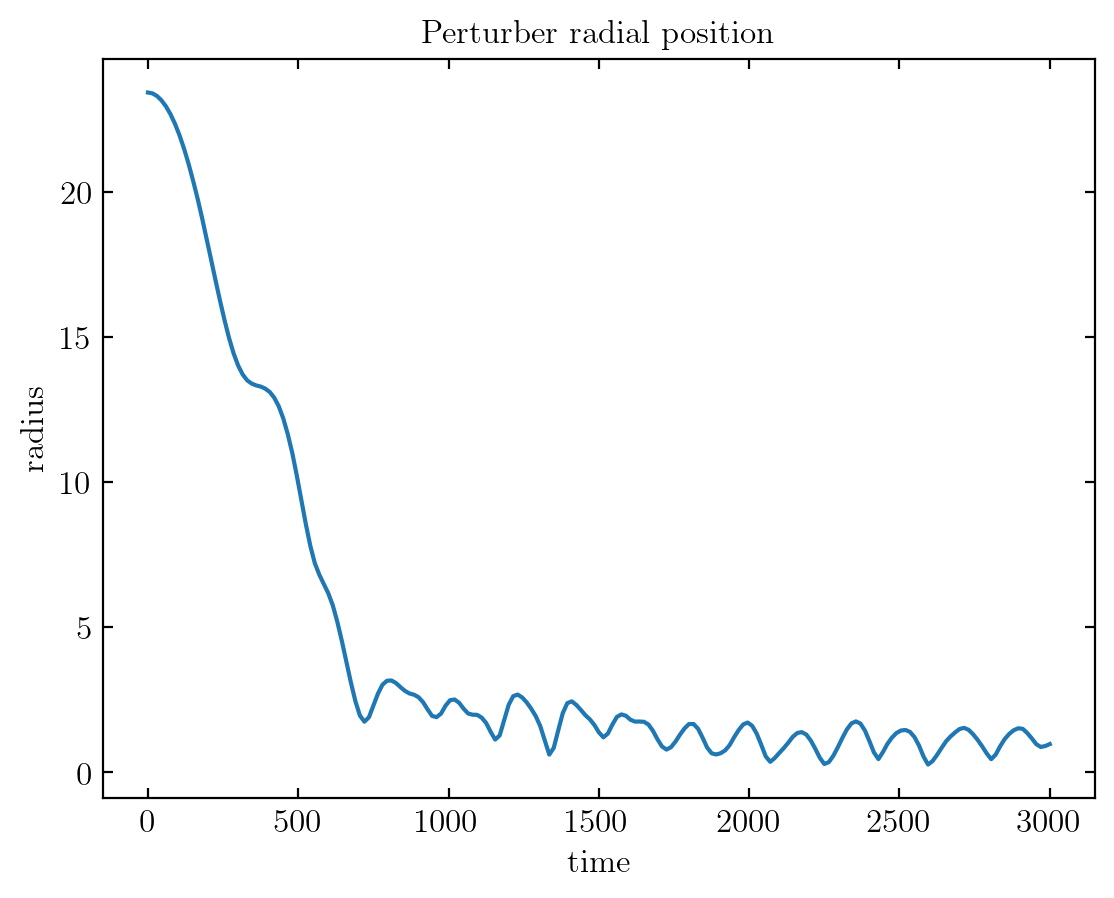

In [37]:
plt.plot(time,r[0,:])
plt.xlabel('time')
plt.ylabel('radius')
#plt.savefig('dyf_radius.png')
plt.title('Perturber radial position')
plt.margins(.05)
plt.show()

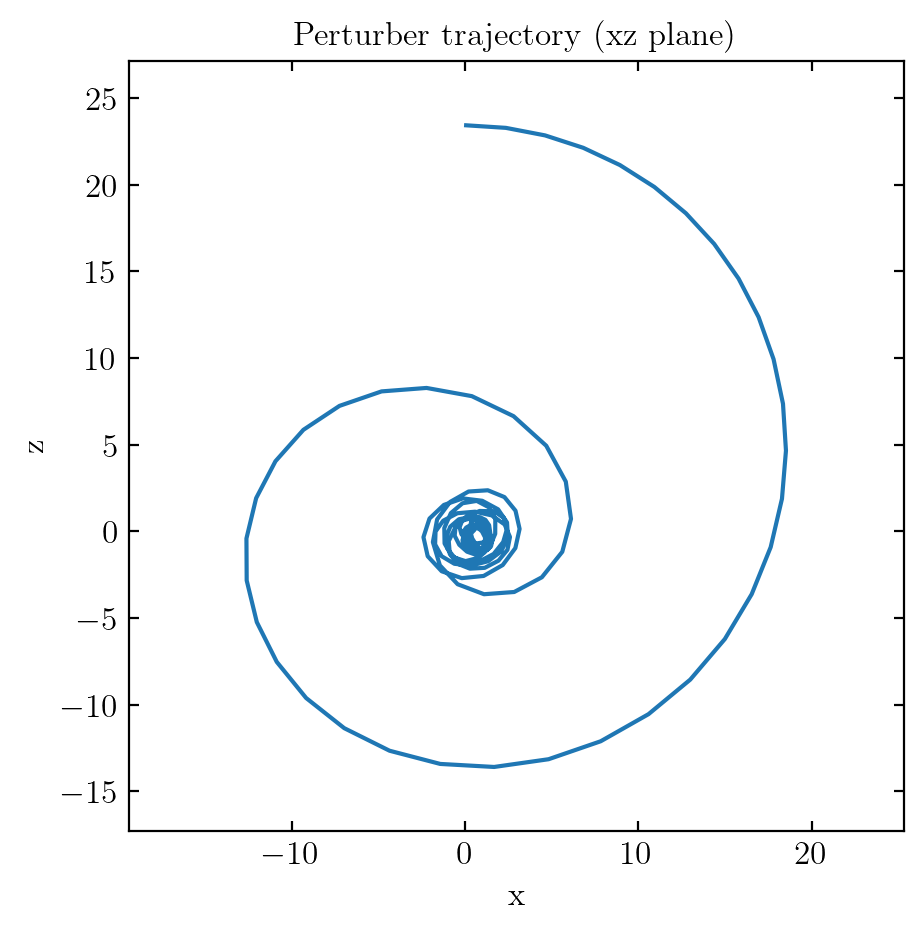

In [38]:
plt.figure(figsize=(5,5))

plt.plot(x[0,:], z[0,:])
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.margins(.1)
plt.title('Perturber trajectory (xz plane)')
plt.show()

## Energy

In mechanics, the virial theorem provides a general equation that relates the average over time of the total kinetic energy of a stable system of discrete particles, bound by potential forces (forces characterized exclusively by potential difference), with that of the total potential energy of the system.

In [39]:
from scipy import linalg

In [40]:
en_file_name = "../data/logout_dyf_005.txt"

In [41]:
en_data = pd.read_csv(en_file_name, header=None).to_numpy()

In [42]:
en_data

array([['Hierarchical N-body code (theta scan)'],
       ['   nbody     dtime       eps     theta   usequad     dtout     tstop'],
       ['   30001   0.10000    0.0300      1.00     false  15.00000 3000.0000'],
       ...,
       ['        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot'],
       ['    3000.076 0.00541 0.02420 0.02962 0.81719 0.00671 0.18638 104.707'],
       ['\tdata output to file out_dyf_005.txt at time 3000.075928']],
      dtype=object)

In [43]:
raws_to_keep = [x + 1 for x in range(0,len(en_data)) if "|T+U|" in en_data[x][0]]
lines = np.array(raws_to_keep)
lines

array([     6,     11,     15, ..., 120178, 120182, 120186])

In [44]:
for i in range(0, len(lines)):
    mask = len(en_data[lines[i]][0]) != 68
    if mask:
        print(len(en_data[lines[i]][0]))
        odd_line = lines[i]
        print(odd_line)

64
55619


In [45]:
times = []
T = []
U = []

for i in range(0, len(lines)):
    if lines[i] != odd_line:
        times.append(float(en_data[lines[i]][0][4:12]))
        T.append(float(en_data[lines[i]][0][21:28]))
        U.append(float(en_data[lines[i]][0][29:36]))
    else:
        times.append(float(en_data[lines[i]][0][0:8]))
        T.append(float(en_data[lines[i]][0][17:24]))
        U.append(float(en_data[lines[i]][0][25:32]))
    
en_times = np.array(times)
Kin_en = np.array(T)
Pot_en = np.array(U)

E_tot = Kin_en - Pot_en

In [46]:
from IPython.display import display, Markdown

Text(0.5, 1.0, 'Total Energy')

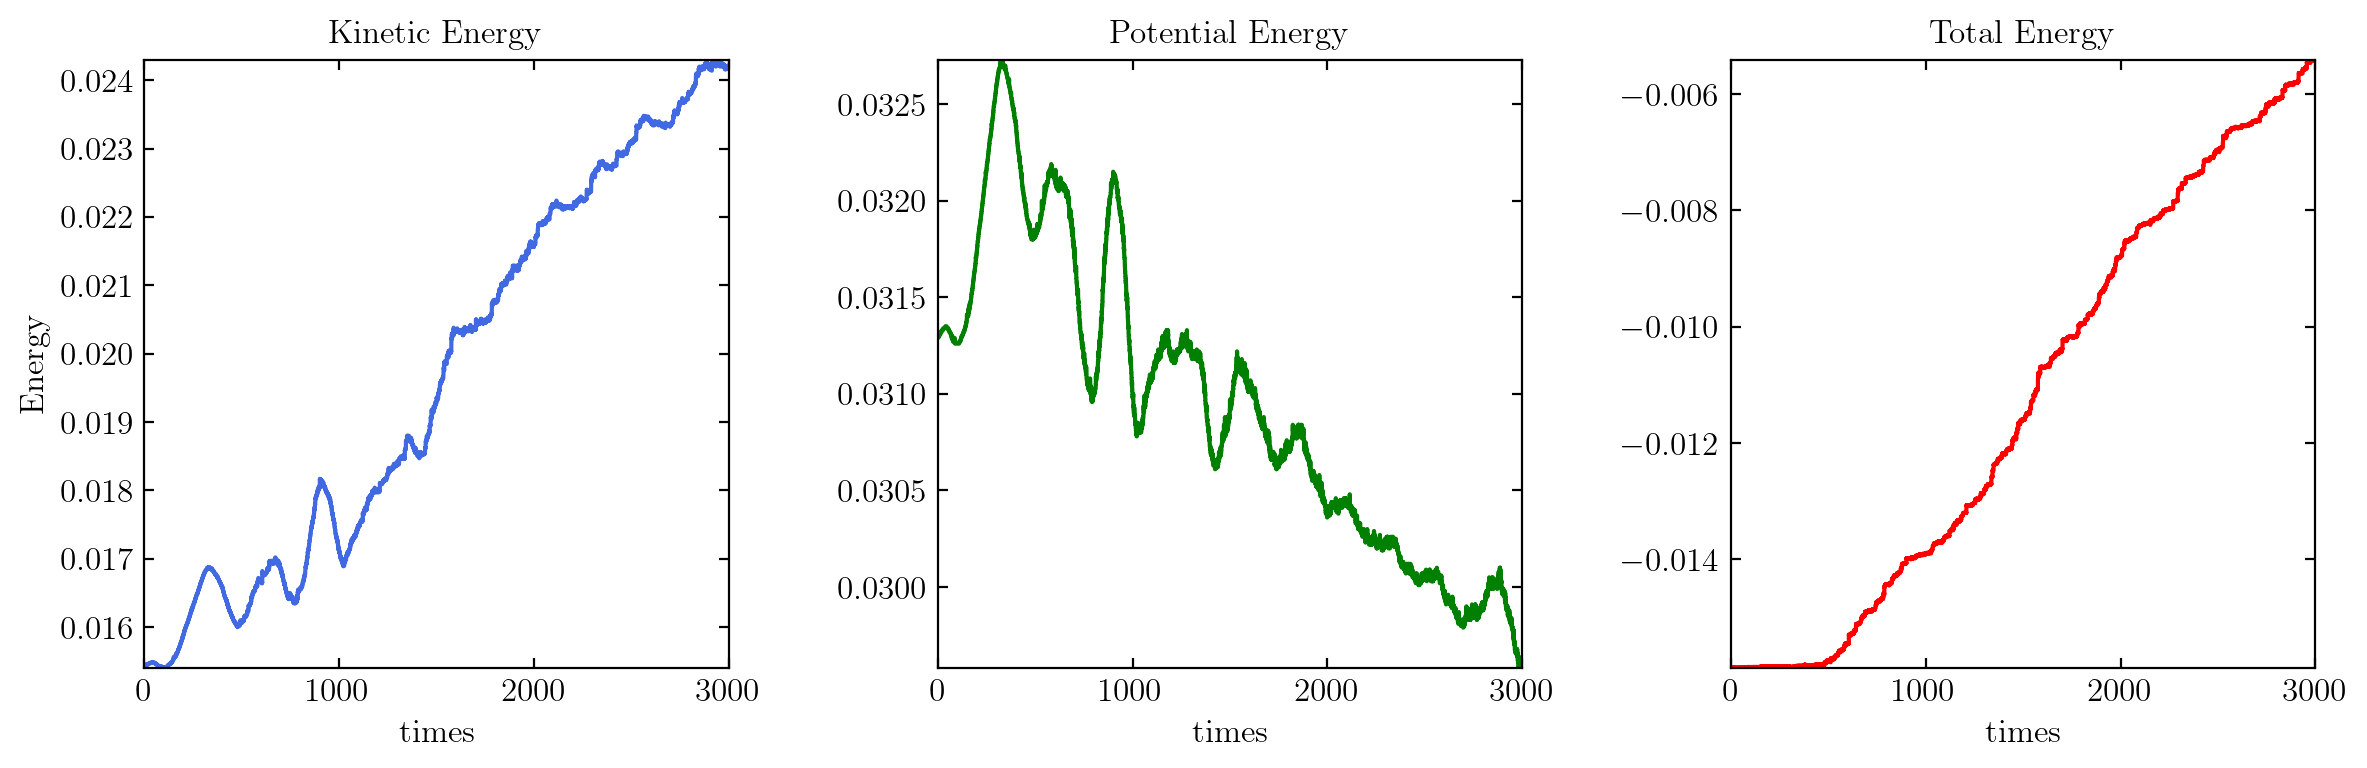

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout={'w_pad': 2})

axs[0].plot(en_times, Kin_en, color = "royalblue", label="Kinetic Energy")
axs[0].set_xlabel("times")
axs[0].set_ylabel("Energy")
axs[0].set_title("Kinetic Energy")

axs[1].plot(en_times, Pot_en, color = "green", label="Potential Energy")
axs[1].set_xlabel("times")
axs[1].set_title("Potential Energy")


axs[2].plot(en_times, E_tot, color = "red", label="Total Energy")
axs[2].set_xlabel("times")
axs[2].set_title("Total Energy")

### Virial analysis

In [48]:
virial_ratios = -Kin_en/(Pot_en)

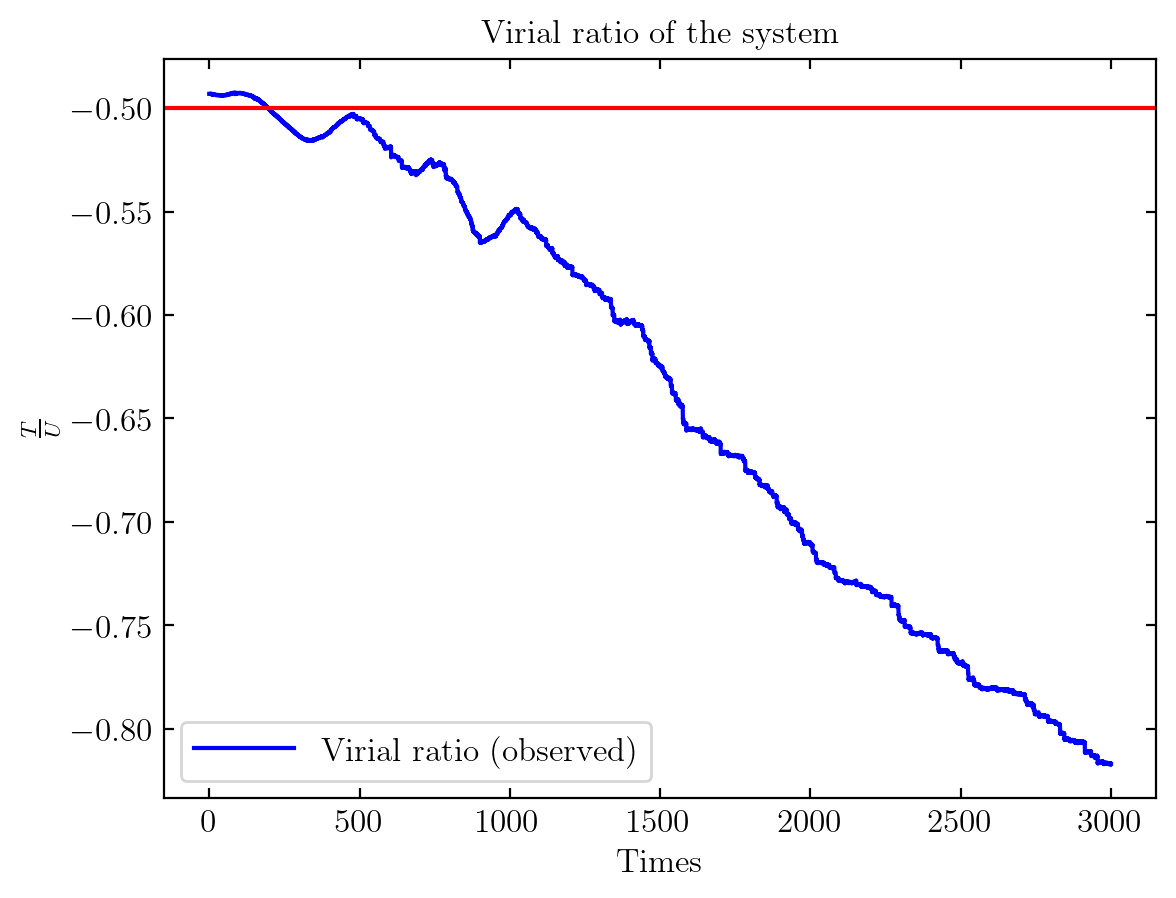

In [49]:
plt.figure()
plt.plot(en_times, virial_ratios, color='blue', label='Virial ratio (observed)')
plt.axhline(xmin=en_times[0], xmax=en_times[-1], y=-0.5, color='r')
#plt.axvline(x=t_dyn, color='green', label="Dynamical time")
#plt.axvline(x=7.*t_dyn, color='orange', label="7 * Dynamical time")


plt.xlabel("Times")
plt.ylabel(r'$\frac{T}{U}$')
plt.title("Virial ratio of the system")
plt.margins(.05)
plt.legend();

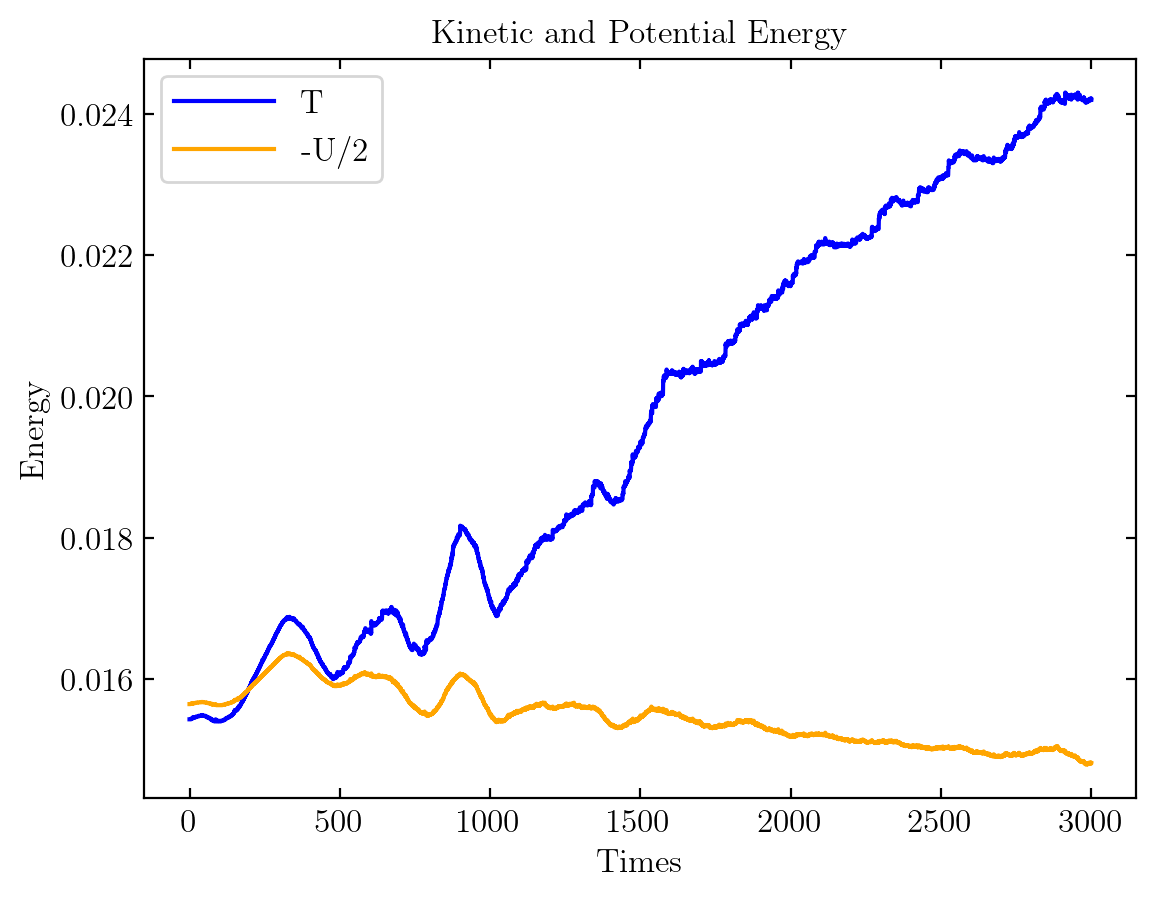

In [50]:
plt.plot(times, Kin_en, color='blue', label='T')
plt.plot(times, Pot_en/2, color='orange', label='-U/2')
plt.xlabel("Times")
plt.ylabel("Energy")
plt.title("Kinetic and Potential Energy")
plt.margins(.05)
plt.legend()

---

## Simulation

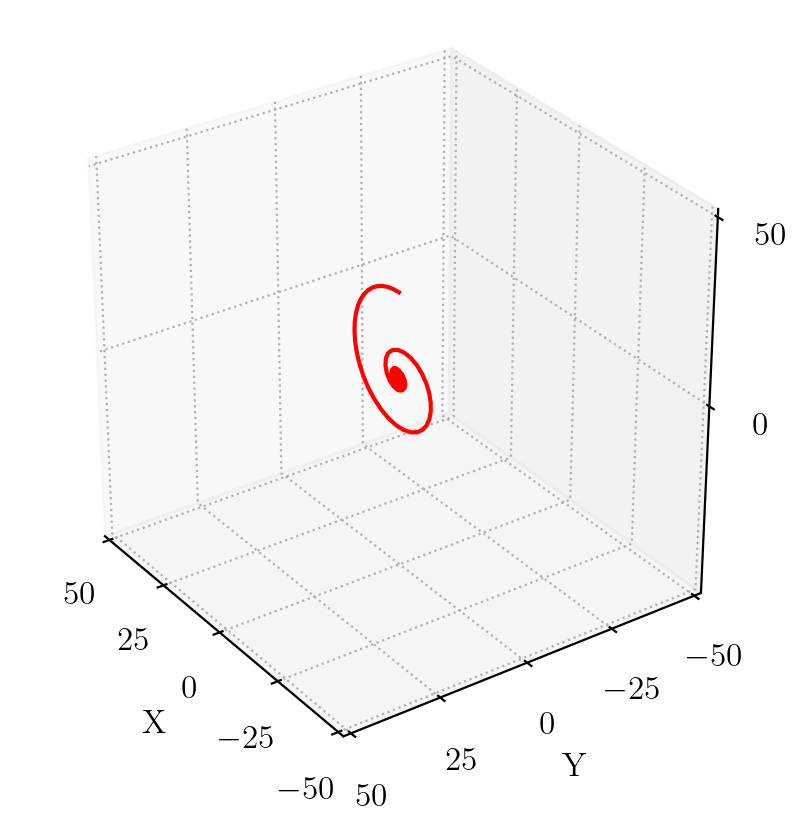

In [51]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(aspect='equal')
#ax.plot3D(x_1, y_1, z_1, 'blue')
ax.plot(x[0,:], y[0,:], z[0,:], 'red')
#plt.title('Two-Body Orbit')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xticks([-100,-75,-50,-25,0,25,50,75,100])
ax.set_yticks([-100,-75,-50,-25,0,25,50,75,100])
ax.set_zticks([0,50,100,150,200,250,300])

neg = -50
pos = 50

ax.axes.set_xlim3d(left=neg, right=pos) 
ax.axes.set_ylim3d(bottom=neg, top=pos) 
ax.axes.set_zlim3d(bottom=neg, top=pos)


ax.view_init(30, 145)  # Changing viewing angle (adjust as needed)
#plt.savefig('dyf_3D.png')
plt.show()

# Animation of the Plummer Sphere 3D

In [ ]:
from matplotlib import animation
from tqdm.notebook import tqdm
from IPython.display import HTML

def update(num):
    global N    #N_particles
    l = 30
    ax.clear()
    
    ax.scatter(x[1:,num], y[1:,num], z[1:,num], color = 'royalblue', s = .5 ,alpha = .02)        # Updating Point Location
    ax.scatter(x[0,num], y[0,num], z[0,num], color = 'red', s = 7.5)
    
    ax.set_title(f'{N} particles, time = {round(time[num],1)}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    
    ax.set_xlim(-l, l)
    ax.set_ylim(-l, l)
    ax.set_zlim(-l, l)
    

## Plotting the Animation
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(aspect='equal')
line_ani = animation.FuncAnimation(fig, update, interval=50,   
                                   frames=tqdm(range(len(time) - 1)));

HTML(line_ani.to_jshtml())

In [ ]:
ffwriter = animation.FFMpegWriter(fps=24)
line_ani.save(f'{f_out}.mp4', writer=ffwriter, dpi = 150)